## Privacy Preserving Record Linkage (PPRL): Field-level bloom filters using double hashing technique

This notebook demonstrates steps to implement privacy preserving record linkage. Privacy preserving record linkage (PPRL) will typically follow five steps which includes:
1. Data pre-processing
2. Privacy preservation
3. Blocking and indexing
4. Comparison
5. Classification
6. Evaluation

In PPRL, consideration needs to be made to preserve the privacy of the personal identifiable information (PII) before the data leaves the source system to a third party system or a linkage agent. As shown in the figure below:

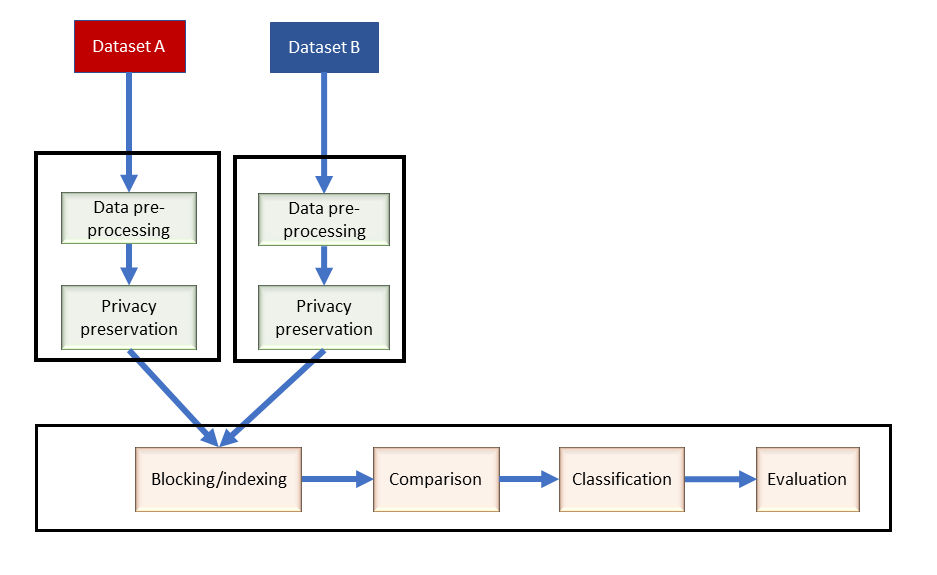

This notebook will demonstrate these six steps. The privacy preservation step is implemented using field-level bloom filters. We will also demonstrate some data pre-processing approach like `phonetic encoding` as well as demonstrate blocking techniques, comparison using dice coefficient similarity on bloom filters and classification using expectation maximization classifier.

This resource is built on the `python record linkage toolkit (PRLT)`. A lot of the resources used in this notebook demonstration can be found on the python record linkage toolkit documentation https://recordlinkage.readthedocs.io/en/latest/

#### Notebook setup
Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import recordlinkage
from recordlinkage.preprocessing import clean, phonetic
from recordlinkage.datasets import load_febrl4
from recordlinkage.index import Block
from recordlinkage.base import BaseIndexAlgorithm
from recordlinkage.compare import Exact, Numeric, String
from recordlinkage.base import BaseCompareFeature

from bitarray import bitarray
from hashlib import sha256
from hashlib import md5
from nltk import ngrams
#from itertools import combinations
#from struct import pack
import random   

from datetime import datetime



#### Import the dataset of interest

<b>The FEBRL datasets. </b>

The Freely Extensible Biomedical Record Linkage (Febrl) package is distributed with a dataset generator `recordlinkage.datasets.load_febrl4` and four datasets generated with the generator. This function returns the fourth Febrl dataset as a pandas.DataFrame.

Generated as one data set with 10000 records 

    * 5000 originals (dataset4a.csv) and 
    * 5000 duplicates (dataset4b.csv), with one duplicate per original 


Parameters:	return_links (bool) – When True, the function returns also the true links.

Returns:(pandas.DataFrame, pandas.DataFrame) – A pandas.DataFrame with Febrl dataset4a.csv and a pandas dataframe with Febrl dataset4b.csv. When return_links is True, the function returns also the true links.

For more information on FEBRL,  http://users.cecs.anu.edu.au/~Peter.Christen/Febrl/febrl-0.3/febrldoc-0.3/manual.html

In [3]:
dfA, dfB, true_links = load_febrl4(return_links= True)

In [4]:
dfA

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688
...,...,...,...,...,...,...,...,...,...,...
rec-2153-org,annabel,grierson,97,mclachlan crescent,lantana lodge,broome,2480,nsw,19840224,7676186
rec-1604-org,sienna,musolino,22,smeaton circuit,pangani,mckinnon,2700,nsw,19890525,4971506
rec-1003-org,bradley,matthews,2,jondol place,horseshoe ck,jacobs well,7018,sa,19481122,8927667


#### <u> 1. Data Pre-processing </u>

<b>Define the data elements from the dataset to use for record linkage </b>

In [5]:
dataset1 = dfA.rename(columns={'given_name': 'firstName', 'surname': 'lastName','postcode':'zip code','soc_sec_id':'social_sn','date_of_birth':'dateOfBirth'})
dataset2 = dfB.rename(columns={'given_name': 'firstName', 'surname': 'lastName','postcode':'zip code','soc_sec_id':'social_sn','date_of_birth':'dateOfBirth'})

In [6]:
#create the linkage dataset1
working_df1 = dataset1[['social_sn','firstName','lastName','zip code','dateOfBirth']]
#create the linkage dataset2
working_df2 = dataset2[['social_sn','firstName','lastName','zip code','dateOfBirth']]
#working_df.head()

In [7]:
working_df1.head() # the dataframe (containing the data elements) to be used for record linkage

,social_sn,firstName,lastName,zip code,dateOfBirth
rec_id,,,,,
rec-1070-org,5304218,michaela,neumann,4223,19151111
rec-1016-org,4066625,courtney,painter,4560,19161214
rec-4405-org,4365168,charles,green,4566,19480930
rec-1288-org,9239102,vanessa,parr,2135,19951119
rec-3585-org,7207688,mikayla,malloney,4552,19860208


#### Data Cleaning

Typically, real world datasets will include some abnormalities including missing data. Data cleaning will need to happen to manage the quality issues with your dataset. The steps will include handling missing data, special characters, ensuring all data are in the same case.  

Step 1: fill all missing values with empty strings.  

In [13]:
#fill missing data with empty string
working_df1 = working_df1.fillna(' ')
working_df2 = working_df2.fillna(' ')

Step 2: handle special characters. The `recordlinkage` library contains a `clean` function that clean strings in the series by removing unwanted tokens, whitespace and brackets. 

When the cleaning is completed, all unwanted characters have been taken out of all the values in the dataset and we are ready to begin the encoding steps

In [14]:
# Dataset 1
working_df1['social_sn_cln'] = clean(working_df1['social_sn'])
working_df1['firstname_cln'] = clean(working_df1['firstName'])
working_df1['lastname_cln'] = clean(working_df1['lastName'])

# ----------------------------------------------------------------
# Dataset 2
working_df2['social_sn_cln'] = clean(working_df2['social_sn'])
working_df2['firstname_cln'] = clean(working_df2['firstName'])
working_df2['lastname_cln'] = clean(working_df2['lastName'])

working_df1.head()

C:\Users\PVP1\Anaconda3\lib\site-packages\recordlinkage\preprocessing\cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
C:\Users\PVP1\Anaconda3\lib\site-packages\recordlinkage\preprocessing\cleaning.py:118: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_none, '')
C:\Users\PVP1\Anaconda3\lib\site-packages\recordlinkage\preprocessing\cleaning.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_whitespace, ' ')
C:\Users\PVP1\Anaconda3\lib\site-packages\recordlinkage\preprocessing\cleaning.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'\s\s+', ' ')


,social_sn,firstName,lastName,zip code,dateOfBirth,social_sn_cln,firstname_cln,lastname_cln
rec_id,,,,,,,,
rec-1070-org,5304218,michaela,neumann,4223,19151111,5304218,michaela,neumann
rec-1016-org,4066625,courtney,painter,4560,19161214,4066625,courtney,painter
rec-4405-org,4365168,charles,green,4566,19480930,4365168,charles,green
rec-1288-org,9239102,vanessa,parr,2135,19951119,9239102,vanessa,parr
rec-3585-org,7207688,mikayla,malloney,4552,19860208,7207688,mikayla,malloney


#### Phonetic Encoding:

The phonetic encoding method is applied to handle errors that may occur due to name misspelling or different variant of names thereby improving the quality of the match process. Example: `Zoey` vs `Zoe`, `Smith` vs `Smyth` etc.  This step convert names or strings into phonetic codes.
We are using the phonetic encoding function `phonetic` contained in the `recordlinkage` library. Different encoding methods exists for this library and they include `soundex`,`metaphone`,`nysiis` and `match-rating`. However, in this use case, we will use the `soundex` nethod because it is the most commonly used of all the four methods listed.

You can choose to use any of the listed methods for your implementation.

We encode `firstname` and `lastname`. The output from this is clean and ready to be converted to bloom filters. 

In [16]:
# Dataset 1
working_df1['enc_firstname_cln'] = recordlinkage.preprocessing.phonetic(working_df1['firstname_cln'], 'soundex', concat=True, encoding='utf-8', decode_error='strict')
working_df1['enc_lastname_cln'] = recordlinkage.preprocessing.phonetic(working_df1['lastname_cln'], 'soundex', concat=True, encoding='utf-8', decode_error='strict')

# -------------------------------------------------------------------------------------------
# Dataset 2
working_df2['enc_firstname_cln'] = recordlinkage.preprocessing.phonetic(working_df2['firstname_cln'], 'soundex', concat=True, encoding='utf-8', decode_error='strict')
working_df2['enc_lastname_cln'] = recordlinkage.preprocessing.phonetic(working_df2['lastname_cln'], 'soundex', concat=True, encoding='utf-8', decode_error='strict')

working_df1.head()

C:\Users\PVP1\Anaconda3\lib\site-packages\recordlinkage\preprocessing\encoding.py:80: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r"[\-\_\s]", "")


,social_sn,firstName,lastName,zip code,dateOfBirth,social_sn_cln,firstname_cln,lastname_cln,enc_firstname_cln,enc_lastname_cln
rec_id,,,,,,,,,,
rec-1070-org,5304218,michaela,neumann,4223,19151111,5304218,michaela,neumann,M240,N550
rec-1016-org,4066625,courtney,painter,4560,19161214,4066625,courtney,painter,C635,P536
rec-4405-org,4365168,charles,green,4566,19480930,4365168,charles,green,C642,G650
rec-1288-org,9239102,vanessa,parr,2135,19951119,9239102,vanessa,parr,V520,P600
rec-3585-org,7207688,mikayla,malloney,4552,19860208,7207688,mikayla,malloney,M240,M450


#### <u>2. Privacy Presevation </u>
All protected information are converted to bloom filters to preseve the privacy of the records. The protected dataset is returned and feeds the record linkage ML model

----------------------

#### Bloom Filter Encoding

A bloom filter is a data structure that tells you whether an element is present in a set in a memory efficient way. The base structure of a bloom filter is a bit vector. Additionally, a bloom filter can be said to be a bit array with all bits set to zero, then a number of hash functions are defined, each mapping to any one of the bits in the bitarray. 

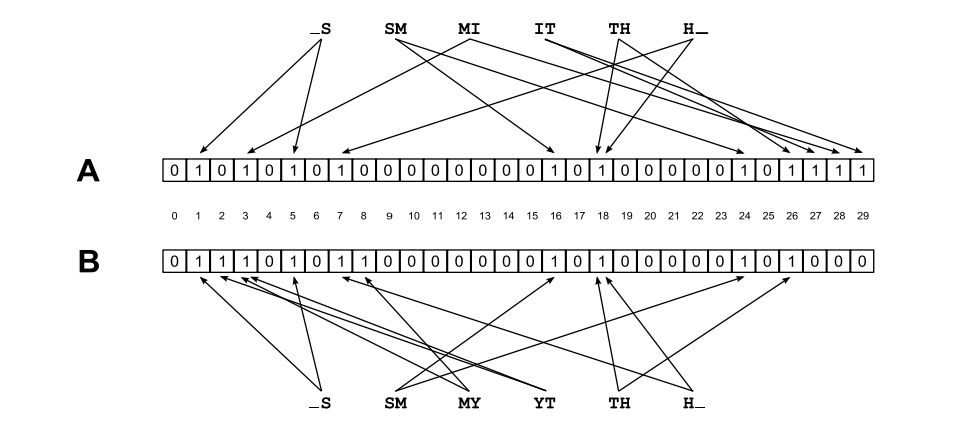
<i>image source:https://bmcmedinformdecismak.biomedcentral.com/track/pdf/10.1186/1472-6947-9-41.pdf </i>


To add an element to the bloom filter, the element is broken down into bigrams, each bigram is then hashed into an integer value and thereafter the bit vector at the index of the hash value is set to 1. <br>
Hash functions used in a bloom filter should have uniform distribution and be independent. Cryptographic and non-cryptographic hashes can be used. However, with using cryptographic hashing, more security is achieved at a trade off for performance. The reverse is the case for non-cryptographic hashes.

Examples of non-cryptographic hashes include `fnv`, `mummur`, `hashmix` etc. while some examples of cryptographic hashes include `MD5`, `SHA1` and the `SHA` families.

To improve privacy preservation, studies have recommended the use of `double hashing` or `random hashing` to reduce risk of re-identification. However, this step does not provide total protection against re-identification. Other bloom filter hardening techniques exist to improve protection and reduce risk of re-identification.  

Double hashing: This is given by: \begin{equation*}
g(x) = h_1(x) + ih_2(x) (mod  p),
where h_1(x) and h_2(x) are two independent, uniform hash functions.
\end{equation*}

Random hashing:

For more details on bloom filters, see https://bmcmedinformdecismak.biomedcentral.com/track/pdf/10.1186/1472-6947-9-41.pdf


In [19]:
l = 1000 #bloom filter length
k = 15 #number of hash functions

# Converts a field to a set of n-grams."""
def n_grams(field):    
    return [''.join(ng) for ng in ngrams(' {} '.format(field), 2)]

# Returns a bit vector with all values set to zero."""
def bit_vector(size):    
    return [0 for _ in range(size)]

# Returns the indices generated by h(x)."""   
def hash_indices(x): 
    s = sha256()
    m = md5()
    if type(x) is str:
        x = x.encode('UTF-8')    
    for h in range(k):
        s.update(x)
        m.update(x)        
        func1 = int(s.hexdigest(), 16)
        func2 = int(m.hexdigest(), 16)
        digest = int((func1 + h*func2) % l) #double hashing function
        yield digest

# construct the bloom filters
def construct_fbf(field):
    bigram = [n_grams(f) for f in field]
    bitvector = [bitarray(bit_vector(l)) for _ in field]
    for (S, v) in zip(bigram, bitvector):
        for x in S:
            for i in hash_indices(x):
                v[i] = 1
    return bitvector

#### Bloom filter Hardening
Bloom filters have some re-identification risk because they are vulnerable to attacks such as `frequency-based cryptanalysis`, `pattern mining attacks` etc. To prevent such attacks, studies proposed several hardening techniques. For more details on bloom filter hardening technique, see https://openproceedings.org/2021/conf/edbt/p64.pdf

Here we implemented the `balancing technique`. The goal of this technique is to achieve a constant `hamming weight` which will make the elimination of infrequent patterns more difficult and hence prevent pattern mining attacks. This is constructed by concatenating a bloom filter with its negative copy and then permuting the newly generated bits. 
The shortfal will this method is that since the size of the bloom filter is doubled, additional computing time and memory is required for comparison functions.

In [20]:
def balance_bf(bf):
    seed = 42
    perm_pos_list = None
    
    # Add complement of the original Bloom filter to itself
    #
    bal_bf = bf + ~bf
    bf_len = len(bf)
    bal_bf_len = len(bal_bf)
    random.seed(seed)
    if (seed != None):  # Permutate the bit positions

        # Generate a permutation list using random shuffling of bit positions
        #
        if (perm_pos_list == None):
            perm_pos_list = [i for i in range(bal_bf_len)] #range(bal_bf_len) #[i for i in range(bal_bf_len)]
            random.shuffle(perm_pos_list)
            perm_pos_list = perm_pos_list

        else:
            perm_pos_list = perm_pos_list

        # Permute the bits in the balanced Bloom filter
        #
        perm_bal_bf = bitarray(bal_bf_len)

        for pos in range(bal_bf_len):
            perm_bal_bf[pos] = bal_bf[perm_pos_list[pos]]
    else:
        perm_bal_bf = bal_bf

    return perm_bal_bf

    #return bal_bf
def harden_bf(bf_list):
    hardened_list = [balance_bf(i) for i in bf_list]
    return hardened_list      

Encode the data elements in our dataset into bloom filters

In [21]:
#convert the selected columns to bloomfilters

# Dataset 1
working_df1['bf_firstname'] = construct_fbf(working_df1['enc_firstname_cln'])
working_df1['bf_lastname'] = construct_fbf(working_df1['enc_lastname_cln'])
working_df1['bf_ssn'] = construct_fbf(working_df1['social_sn_cln'])
working_df1['bf_dob'] = construct_fbf(working_df1['dateOfBirth'])

#-----------------------------------------------------------------------------------------
# Dataset 2
#convert the selected columns to bloomfilters
working_df2['bf_firstname'] = construct_fbf(working_df2['enc_firstname_cln'])
working_df2['bf_lastname'] = construct_fbf(working_df2['enc_lastname_cln'])
working_df2['bf_ssn'] = construct_fbf(working_df2['social_sn_cln'])
working_df2['bf_dob'] = construct_fbf(working_df2['dateOfBirth'])

# -----------------------------------------------------------------------------------------
#create the privacy preserved dataset ready to be shared and for record linkage. 
final_dataset1 = working_df1[['bf_ssn','bf_firstname','bf_lastname','bf_dob','zip code']]
final_dataset2 = working_df2[['bf_ssn','bf_firstname','bf_lastname','bf_dob','zip code']]
final_dataset1.head()

,bf_ssn,bf_firstname,bf_lastname,bf_dob,zip code
rec_id,,,,,
rec-1070-org,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4223
rec-1016-org,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4560
rec-4405-org,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4566
rec-1288-org,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2135
rec-3585-org,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",4552


#### <u>3. Blocking & Indexing </u>

Indexing creates record pairs from the 2 datasets to be linked. The result is often refered to as candidate pairs or candidate match (pair of records you want to check if they match or not). In a real world scenario, running your matching/linkage algorithm on these record pairs can be very expensive. For example, if you have 5000 records on each of datasets A and B, indexing will create the product of these datasets resulting in 25,000,000 candidate pairs to compare. Majority of these candidate pairs are likely not going to result in a match. 

Blocking is a technique to reduce the number of candidate pairs and not leave out any possible true match. Hence applying a blocking technique on datasets A and B as above can reduce the number of candidate pairs to 150,000 limiting the number of pairs to compare as long as all (or nearly all) true matches are identified. Blocking will usually consider available data in the dataset to check for possibility of a match to determine candidate pairs. 

In the use case below, we wrote a user-defined algorithm based on PRLT's `recordlinkage.base.BaseindexAlgorithm` which is an abstract base class used for indexing algorithms. Our algorithm takes two dataframes, checks the dice similarity (see explanation below) on last names of both datasets for all records and returns only candidate pairs with a match on the last name (where last names on both datasets are the same).  

In [23]:
def dice_coefficient(bf1, bf2):
    bf1 = np.asarray(bf1).astype(bool)
    bf2 = np.asarray(bf2).astype(bool)

    if bf1.shape != bf2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(bf1, bf2)

    return 2. * intersection.sum() / (bf1.sum() + bf2.sum())

In [24]:
# block on lastname only 
class BlockBloomfiltersOnLastname(BaseIndexAlgorithm):

    def _link_index(self, df_a, df_b):
        block_lst = []
        for i, bf_b in enumerate(df_b['bf_lastname']):
            block = [(df_a.index[x],df_b.index[i]) for x, bf_a in enumerate(df_a['bf_lastname']) if dice_coefficient(bf_b,bf_a) == 1]                  
            block_lst.extend(block)
        return pd.MultiIndex.from_tuples(block_lst, names=[df_a.index.name, df_b.index.name])
    
#blocking on lastname
indexerl = BlockBloomfiltersOnLastname()
begin = datetime.now()

candidates = indexerl.index(final_dataset1, final_dataset2)
#candidates

finish = datetime.now()
ttcl = finish-begin
candidatesl_count = len(candidates)

#### <u>4. Comparison </u>

The python `recordlinkage` toolkit has some defined classes for comapring similarities between record pais. This includes methods to compare strings, numerical measures, distance measures etc. <br>
However, because our dataset contains `bloomfilters` which are of type `bytearray`, we needed to find a different way to compare the bloomfilter record pairs. In our use case, we are using the `Dice coefficient`. See description below.<br> <br>
We overwrite the abstract method `recordlinkage.base.BaseCompareFeature._compute_vectorized()` in the base class with our user-defined algorithm composed of the `dice coefficient` function. See the `CompareBloomFilters` class below.

---
<b>Sørensen–Dice coefficient</b> </br> 
Dice coefficient (Sørensen–Dice coefficient) is a measure of set similarity (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient). Given two sets X and Y, the formula for dice similarity coefficient is given by:

\begin{equation*}
DSC = \frac{2*|X \bigcap Y|}{|X|+|Y|} 
\end{equation*}

----
<b>Parameters</b> </br>  
X : array-like, bool (Any array of arbitrary size. If not boolean, will be converted.) </br>   
Y : array-like, bool (Any other array of identical size to X. If not boolean, will be converted.) </br> 
<b>Note:</b> The order of inputs for `dice` is irrelevant. The result will be identical if `X` and `Y` are switched.

----
<b>Returns</b> </br>  
dice : float

    Dice coefficient as a float on range [0,1].
    Maximum similarity = 1
    No similarity = 0


In [26]:
class CompareBloomFilters(BaseCompareFeature):

    def _compute_vectorized(self, df1, df2):

    # If the bloomfilters in both records are identical, the similarity is 1.
    # If they are not identical the similarity is 0. 
    # The closer they bloomfilters are, the similarity tends to 1.

        lst = []
        # we pick a single bloom filter from each of the series, df1, df2, convert them to boolean, 
        # get the intersection which is a logical and operation and then 
        # calculate the similarity of the 2 bloom filters based on the formular stated in the introduction cell above
        for i in range(len(df1)): 
            #converts the bloom filter from the series to boolean types
            array1 = np.asarray(df1.iloc[i]).astype(bool) 
            array2 = np.asarray(df2.iloc[i]).astype(bool) 
            # logical and operation
            intersection = np.logical_and(array1, array2) 
            # calculate the similarity score between the 2 bloom filters
            similarity = 2. * intersection.sum() / (array1.sum() + array2.sum()) # 
            lst.append(similarity)
        
        #convert the list of similarities to a series. The compute method requires either a series or a numpy array
        similarity_list = pd.Series(lst)
    
        return similarity_list

In [27]:
#initialise the compare methods
comp = recordlinkage.Compare()

# initialise similarity measurement algorithms
comp.add(CompareBloomFilters('bf_firstname', 'bf_firstname', label='firstname'))
comp.add(CompareBloomFilters('bf_lastname', 'bf_lastname', label='lasttname'))
comp.add(CompareBloomFilters('bf_ssn', 'bf_ssn', label='ssn'))
#comp.exact('gender_cln', 'gender_cln', label='gender')
#comp.add(CompareBloomFilters('bf_phone', 'bf_phone', label='phoneNumber'))
comp.add(CompareBloomFilters('bf_dob', 'bf_dob', label='dob'))
comp.exact('zip code', 'zip code', label='zipCode')

#verify the features. gives a list of the algorithms to create
comp.features

[<CompareBloomFilters 'firstname'>,
 <CompareBloomFilters 'lasttname'>,
 <CompareBloomFilters 'ssn'>,
 <CompareBloomFilters 'dob'>,
 <Exact 'zipCode'>]

In [28]:
# the method .compute() calculates the similarities across the record pairs and returns the DataFrame with the feature (similarity) vectors.  
# -- candidates - contains the multiIndex record pairs to compare
# -- dataset1, dataset2 - the dataframes you are matching
comparison_output = comp.compute(candidates, final_dataset1, final_dataset2)



#### <u> 5. Classification </u>

Classification is a step in record linkage process where record pairs are classified as matches and non matches. This is refered to as binary classification. In a situation where record pairs are classified as matched, non-matches and possible matches, this is refered to as multi-class classification. 

Classification can be supervised or unsupervised. Examples of supervised classification algorithms based on the Python record linkage toolkit include: `logisticregressionClassifier`, `NaiveBayesClassifiers`, `SVMClassifiers` etc. Unsupervised classification algorithms include: `ExpectationMaximizationClassifier`, `KMeansClassifier` etc. 

We showed in this notebook a simple example of binary classification using an unsupervised classification algorithm (`Expectation Maximization classifier`) from the python record linkage toolkit.

A detailed notebook is also provided (`link to the notebook`) to demonstrate other classification algorithms not included in the python record linkage toolkit and specific to PPRL.

#### Record linkage Expectation Maximization Classifier

In [31]:
t_index = len(final_dataset1) * len(final_dataset2)

In [34]:
ecm = recordlinkage.ECMClassifier()
data = comparison_output
data = data > 0.75 
col_list = ['firstname','lasttname','ssn','dob','zipCode']
for x in col_list:
    data[x] = data[x].map({True:1,False:0})

ecm_links = ecm.fit_predict(data)

#### <u>6. Evaluation </u>

<b>Linkage Quality Measures: </b></br></br>
F score:  F-score is the harmonic mean of Precision and Recall, calculated as 
\begin{equation*}
F score = \frac{2 × (Precision × Recall)}{(Precision + Recall)} 
\end{equation*}
</br>
Precision : Precision is the fraction of record pairs classified as matches by a decision model that are true matches. Precision is calculated as: 
\begin{equation*}
Precision = \frac{TM}{TM + FM} 
\end{equation*}
</br>
Sensitivity/Recall: This is the fraction of true matches that are correctly classified as matches by a decision model. The formula is given below as: 
\begin{equation*}
Recall = \frac{TM}{TM + FN} 
\end{equation*}
</br>

<b>Blocking technique Measures: </b></br></br>
Pairs completeness (PC): This measures the effectiveness of a blocking technique in the record linkage process. In simple terms, how much of the true matches are contained in the candidate pair after blocking. The formula for calculating pair completeness is given as:
\begin{equation*}
PC = \frac{BM}{TM + FN} 
\end{equation*}
</br>
Reduction ratio (RR): This measures how much a blocking technique is able to reduce the number of candidate record pairs that are beign generated. The formular for calculating reduction ration is given as:
\begin{equation*}
RR = 1 - \frac{BM + BN}{TM + FN + FM + TN} 
\end{equation*}
</br>

BM: true matches included in the candidate record pairs generated by blocking </br>
BN: true non-matches included in the candidate record pairs </br>
TM: True matches based on the classification model</br>
TN: True non-matches based on the classification model</br>
FM: False matches based on the classification model</br>
FN: False non-matches based on the classification model

In [35]:
comparison_output['true_links'] = [True if comparison_output.index[x] in list(true_links) else False for x in range(len(comparison_output))]
BMl = comparison_output['true_links'].sum()
cm = rl.confusion_matrix(true_links, ecm_links,len(data))
TM = cm[0][0]
FN = cm[0][1]
FM = cm[1][0]
TN = cm[1][1]
PCl = BMl/(TM + FN)
RRl = 1 - candidatesl_count/t_index
# f score
fscorel = rl.fscore(true_links,ecm_links)
# Precision
precisionl = rl.precision(true_links,ecm_links)
# Recall/Sensitivity
recalll = rl.recall(true_links,ecm_links)
#print('F score =',(fscorel), ', Precision =',precisionl,', Sensitivity =', recalll,', Pair Completeness =', PCl)

Evaluation_results = {'Measure':['Pairs Completeness (PC)','Reduction ratio (RR)','F score','Precision','Sensitivity (Recall)'], \
                      'Score':[PCl,RRl,fscorel,precisionl,recalll]}

pd.DataFrame(Evaluation_results)

C:\Users\PVP1\Anaconda3\lib\site-packages\recordlinkage\measures.py:147: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return len(links_true & links_pred)
C:\Users\PVP1\Anaconda3\lib\site-packages\recordlinkage\measures.py:179: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  return int(total) - len(links_true | links_pred)


,Measure,Score
0,Pairs Completeness (PC),0.778600
1,Reduction ratio (RR),0.995184
2,F score,0.875394
3,Precision,1.000000
4,Sensitivity (Recall),0.778400
